## DSGE w. Feedback - Numerical Simulations

### Imports

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [11]:
import model
import steadystate
import graphs

## Simulation mechanics

In [4]:
def c_bound(z: float, k: float, p:dict):
    """Upper bound on the amount that can be consumed
    
    .. math:: c_t \leq z_t\cdotk_t\cdot\alpha^{-\frac{1}{\mu}}
    
    
    Parameters
    ----------
    z : float
        Level of productivity
    k : float
        Level of capital at t
    p : dict
        Parameters from simulation
        
    Returns
    -------
    bound : float
        Upper bound on consumption
    """
    return z * k * p['alpha'] ** (-1 / p['mu'])


def bisection(z:float, g:float, k:float, p:dict, precision:float=1e-7):
    """ Determine the level of consumption using the bisection method
    
    .. math:: \frac{2\gamma}{1-\alpha} c_t -  G_t z_t \left(c_t^{-\mu } z_t^{\mu }\right)^{-\frac{\mu +1}{\mu }} \left(\frac{c_t^{-\mu } z_t^{\mu }-\alpha  k_t^{-\mu }}{1-\alpha }\right)^{\frac{2}{\mu }+1} = 0
    
    
    Parameters
    ----------
    z : float
        Level of productivity
    g : float
        Consumption rate (% of income consumed)
    k : float
        Level of capital at t
    p : dict
        Parameters from simulation
    precision : float, default: 1e-5
        Precision of the bisection solution
    
    Returns
    -------
    c : float
        level of consumption
    """
    
    # Pre-compute constants
    mu = p['mu']
    lhs_1 = 2 * p['gamma'] / (1 - p['alpha'])
    rhs_1 = g * z / ((1 - p['alpha']) ** (2 / mu + 1))
    rhs_2 = p['alpha'] * k ** (-1 * mu)
    
    # Minimisation target for the bisection
    def diff(c: float):
        r = z / c
        rhs = rhs_1 * (r ** (-1 - mu)) * ((r ** mu) - rhs_2) ** (2 / mu + 1)
        return c * lhs_1 - rhs
    
    max_val = c_bound(z, k, p)
    
    # Adapt by precision to avoid asymptotic bounds
    edge = precision * 1e-2
    x = [edge, max_val / 2, max_val-edge]
    abs_lst = [abs(diff(i)) for i in x[:2]]

    # Conditions to stop: difference too small OR too close to the bound
    while all([min(abs_lst) >= precision, max_val - x[0] >= precision]):
        test = np.sign([diff(i) for i in x])
        if test[0] == test[1]:
            x = [x[1], (x[1] + x[2]) / 2, x[2]]
        elif test[1] == test[2]:
            x = [x[0], (x[0] + x[1]) / 2, x[1]]     
        
        abs_lst = [abs(diff(i)) for i in x[:2]]

    return x[np.argmin(abs_lst)]

In [5]:
def step(t: float, x: np.ndarray, p: dict, err:float):
    """Iteration of one step in the simulation
    
    Parameters
    ----------
    t : float
        Current timestep t
    x : np.ndarray
        state variables z, c, n, b, w, k, q, g, s, news, inc, xiz, xin
    p : dict
        Parameters from simulation
        
    Returns
    -------
    bound : float
        Upper bound on consumption
    """
    # Starting variables
    z_, c_, n_, b_, w_, k_, q_, g_, s_,s0, news_, inc_, xiz_, xin_, crisis_ = x
        
    # Random technology process
    rand = np.random.normal(0, p['sigmaZ'])
    xiz = p['etaZ'] * xiz_ + np.sqrt(1 - p['etaZ'] ** 2) * rand
    z = p['zbar'] * np.exp(xiz)
    
    # Observe "State of economy"
    g = g_
    
    s = .5*((p['s_max']-p['s_min'])*np.tanh(p['s_theta']*(s_ - s0)) + (p['s_max']+p['s_min']))

    # Determine Consumption
    c = bisection(z, g, k_, p)
    
    # Working hours via market clearing
    n = ((c / z) ** (-1 * p['mu']) - p['alpha'] * k_ ** (-1 * p['mu']))
    n = (n / (1 - p['alpha'])) ** (-1 / p['mu'])
    
    # Firm observes desired working hours, sets the wage accordingly
    rho = -1 * p['mu']
    temp = (p['alpha'] * k_ ** rho + (1 - p['alpha']) * n ** rho) 
    temp = temp ** ((1 / rho) - 1)
    w = (1 - p['alpha']) * z * temp * (n ** (rho - 1))
    
    # Income
    income = w * n + (b_  + q_ * k_) / (1 + p['inflation'])
    #test = [income>0, w>0, n>0, k_>0, q_>0, b_>0]
    #assert all(test), print("w:{:.2f} n:{:.2f} b:{:.2f} q:{:.2f} k:{:.2f}".format(w,n,b_,q_,k_))
    
    # Investment & Bonds
    investment = income * (1 - g)
    b = (1 + p['interest']) * s * investment
    

        
    
    # Capital & Risky return
    k = (1 - p['depreciation']) * k_ + investment * (1 - s)
    q = p['alpha'] * z * temp * (k ** (rho - 1))
    
    
    # Retain previous news formula out of interest
    xin = np.random.normal(0, p['sigmaN'])
    info = p['n_cons']*(c/c_ - 1)
    step_news = p['n_persistence'] * news_ + (1 - p['n_persistence']) * info + xin
    news = np.tanh(p['n_theta'] * step_news)
    crisis  = .5*(1+np.sign(n-k))
    #print((c/c_ - 1), (q-p['interest'])/(q+p['interest']))
    s0 = p['sentiment']*(c/c_ - 1) + (1-p['sentiment'])*((q-p['interest'])/(q+p['interest']))
    #print(s0,'  ',(q/p['interest'] -1))
    
    return z, c, n, b, w, k, q, g, s,s0, news, income, xiz, xin, crisis

In [6]:
def simulate(start: np.ndarray, p: dict, t_end: float = 1e3, err:float=1e-4):
    """ Complete a t_end period simulation of the whole system
    
    Parameters
    ----------
    start : np.ndarray
        starting variables z, c, n, b, w, k, q, g, s, news, inc, xiz, xin
    p : dict
        Parameters from simulation
    t_end : float
        Duration of the simulation
        
    Returns
    -------
    df : pd.DataFrame
        timeseries of the simulation results
    """
    x = np.empty((int(t_end), len(start)))
    x[0, :] = start
    for t in range(1, int(t_end)):
        x[t, :] = step(t, x[t - 1, :], p, err)
        if any([x[t,1]<err, x[t,2]<err, x[t,5]<err]): # c, n, k
            break
    x = x[:t+10,:]
    cols = ['z', 'c', 'n', 'b', 'w', 'k', 'q', 'g', 's','s0', 'news', 'income', 'xiz', 'xin', 'crisis']
    df = pd.DataFrame(x, columns=cols)
    df.loc[:,'inv'] = 100 * (1-df.loc[:,'g'])
    df.loc[:,'bc'] = df.b / df.c
    return df

----
## Interactive Analysis

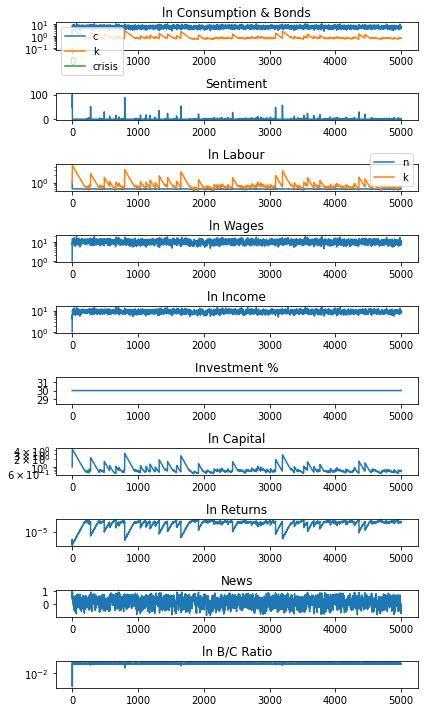

In [12]:
%matplotlib inline
collect = []
sen =[0,.01,.1,.3]
for test in sen:
    params = {'etaZ': 0.2, 'sigmaZ': 0.2, 'zbar': 10.0, 'sigmaN': 0.2, 
              'inflation': 0.01, 'interest': 0.1, 'depreciation': 0.01, 
              'g_min': 0.9, 'g_max': 1-1e-4, 's_min': 1e-4, 's_max': 1-1e-4,'s_theta':5, 
              'n_cons': 10, 'n_theta': 1, 'n_persistence': 0.9, 
              'gamma': 1.0, 'alpha': 0.33, 'mu': 12.32, 'sentiment' :1-test}

    start = dict(z=1, c=1, n=1, b=1, w=1, k=1, q=0.0, g=0.7, s=.5,s0 = 1, income=1, news=1, xiz=0, xin=0, crisis = .1)
    start = np.array([v for _,v in start.items()])

    T = 5000
    np.random.seed(40)
    view = (0,T )

    df = simulate(start, params, T)
    df = df.iloc[view[0]:view[1],:]
    collect.append(df)

plots = {
        'ln Consumption & Bonds' : [df.loc[:,['c','k','crisis']], True],
        'Sentiment' : [100*(1-df.s), False],
        'ln Labour' : [df.loc[:,['n','k']], True],
        'ln Wages' : [df.w, True],
        'ln Income' : [df.income, True],
        'Investment %' : [df.inv, False],
        'ln Capital' : [df.loc[:,['k']], True],
        'ln Returns' : [df.q, True],
        'News' : [df.news, False],
        'ln B/C Ratio' : [df.bc, True],
    }


axs = graphs.simulation_graph(plots, size = (6, 10))
#axs['ln Returns'].axhline(params['interest'], color='red', linewidth=0.5)
plt.show()
#plt.savefig('/Users/fedemoro/Desktop/test.eps', format = 'eps')

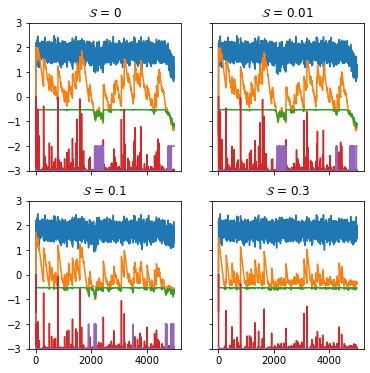

In [14]:
fig, ax =plt.subplots(2,2,sharex = 'col', sharey = 'row', figsize = (6,6))
for i in range(len(sen)):
    i1 = int(i/2)
    i2 = np.mod(i,2)
    ax[i1,i2].plot(np.log(collect[i].c), label = r'$\log$ Capital')
    ax[i1,i2].plot(np.log(collect[i].k), label = r'$\log$ Capital')
    ax[i1,i2].plot(np.log(collect[i].n), label = r'$\log$ Labour')

    ax[i1,i2].plot(3*(1-collect[i].s) - 3, label = r'Capital investments')
    ax[i1,i2].plot(collect[i].crisis-3)
    ax[i1,i2].set_title(r'$\mathcal{S}$ = ' + str(sen[i]))
    ax[i1,i2].set_ylim([-3,3.])

    #ax[i1,i2].set_title(str(sen[i]))
#plt.savefig('/Users/fedemoro/Desktop/kvsn.eps', format = 'eps')

In [15]:
def crises_len(v):
    crisis = []
    for i in range(1,len(v)-1):
        cr_len = 0
        count = 0
        bool_cr = False
        if v[i] == 1 and v[i-1] == 0:
            bool_cr = True
            count = 1
            
        while bool_cr:
            if v[i+count]==1 and i + count < len(v)-1:
                count+=1
            else:
                bool_cr = False
        i+=count
        if count !=0 :
            crisis.append(count)
    return crisis

In [16]:
crisis = []
for i in range(len(sen)):
    crisis.append(crises_len(collect[i].crisis) )

<ipython-input-18-d1cc99a4c382>:5: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  inv = np.histogram((1-collect[i].s), bins = np.logspace(-4,0,100), normed = True)
<ipython-input-18-d1cc99a4c382>:6: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  cris = np.histogram((crisis[i]), bins = np.logspace(0,2,50), normed = True)
<ipython-input-18-d1cc99a4c382>:5: VisibleDeprecationWarning: Passing `n

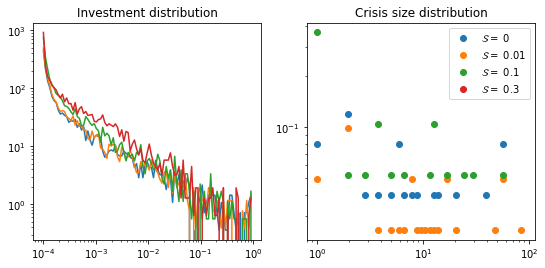

In [18]:
fig, ax =plt.subplots(1,2,sharex = 'col',figsize = (9,4))
for i in range(len(sen)):
    i1 = int(i/2)
    i2 = np.mod(i,2)
    inv = np.histogram((1-collect[i].s), bins = np.logspace(-4,0,100), normed = True)
    cris = np.histogram((crisis[i]), bins = np.logspace(0,2,50), normed = True)
    ax[0].plot(inv[1][:-1],inv[0], label = r'$\mathcal{S}= $ '+str(sen[i]))
    ax[1].plot(cris[1][:-1],cris[0],'o', label = r'$\mathcal{S}= $ '+str(sen[i]))
    #ax[i1,i2].plot(np.log(collect[i].k), label = r'$\log$ Capital')
    #ax[i1,i2].plot(np.log(collect[i].n), label = r'$\log$ Labour')

    #ax[i1,i2].plot(3*(1-collect[i].s) - 3, label = r'Capital investments')
    #ax[i1,i2].plot(collect[i].crisis-3)
    ax[0].set_title(r'Investment distribution')
    ax[1].set_title(r'Crisis size distribution')
    ax[0].set_yscale('log')
    ax[0].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_xscale('log')
plt.legend()
    #ax[i1,i2].set_title(str(sen[i]))
#plt.savefig('/Users/fedemoro/Desktop/inv_distr.pdf', format = 'pdf')

In [ ]:
def steady_state_simulate(start: np.ndarray, p: dict, t_max: float = 2e3, err:float=1e-4):
    """ Complete a t_end period simulation of the whole system
    
    Parameters
    ----------
    start : np.ndarray
        starting variables z, c, n, b, w, k, q, g, s, news, inc, xiz, xin
    p : dict
        Parameters from simulation
    t_end : float
        Duration of the simulation
        
    Returns
    -------
    df : pd.DataFrame
        timeseries of the simulation results
    """
    #x = np.empty((int(t_max), len(start)))
    prior = start
    t = 1
    cond = 1
    while cond:
        new = step(t, prior, p, 1e-5)
        t +=1 
        cond = all([
            abs(new[5]-prior[5]) > err,
            any(np.isnan(new))==False,
            t <= t_max])
        prior = new
    
    cols = ['z', 'c', 'n', 'b', 'w', 'k', 'q', 'g', 's', 'news', 'income', 'xiz', 'xin']
    return pd.Series(new, index=cols)

def utility(c:float, n:float, gamma:float):
    return np.log(c) - gamma * n ** 2

In [ ]:
#from itertools import product

# Parameters to vary
num = 25
T = 2e3
err = 1e-4
macro_vars = ['c', 'n', 'b', 'k', 'q', 'w']

# Parameter Variations
g_list = np.linspace(1e-3, 1-1e-3, num)
s_list = np.linspace(1e-3, 1-1e-3, num)

# Given parameters
params = {'etaZ': 0.2, 'sigmaZ': 0.0, 'zbar': 1.0, 'sigmaN': 0.2, 
          'inflation': 0.01, 'interest': 0.01, 'depreciation': 0.04, 
          'g_min': 0.9, 'g_max': 1-1e-4, 's_min': 0.5, 's_max': 1, 
          'n_cons': 10, 'n_theta': 1, 'n_persistence': 0.9, 
          'gamma': 1.0, 'alpha': 0.33, 'mu': 0.32}

results = {v:np.empty((num,num)) for v in macro_vars}

def sim_vars(g, s):
    start = dict(z=1, c=1, n=1, b=1, w=1, k=1, q=0.1, g=g, s=s, income=1, news=1, xiz=0, xin=0)
    start = np.array([v for _,v in start.items()])
    x = steady_state_simulate(start, params, t_max=T, err=err)
    x = x[[u, c, k, n]]
    return 

# Test 1
res = {k:pd.DataFrame(index=g_list, columns=s_list, dtype=float) for k in macro_vars}

for g, s in product(g_list,s_list):
    x = sim_vars(g,s)
    for k in res.keys():
        res[k].loc[g,s] = x.loc[k]

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8, 12))
for i, k in enumerate(res.keys()):
    r, c = i//2, i%2
    ax[r, c].set_title(k)
    q = ax[r, c].contourf(s_list, g_list, res[k])
    ax[r, c].set_xlabel('s')
    ax[r, c].set_ylabel('g')
    cbar = plt.colorbar(q, ax=ax[r, c])
    
fig.tight_layout()
plt.savefig('fig_steady_state_heatmap2.pdf', bbox_inches='tight', format='pdf')

In [243]:
def crises_len(v):
    crisis = []
    for i in range(1,len(v)-1):
        cr_len = 0
        count = 0
        bool_cr = False
        if v[i] == 1 and v[i-1] == 0:
            bool_cr = True
            count = 1
            
        while bool_cr:
            if v[i+count]==1 and i + count < len(v)-1:
                count+=1
            else:
                bool_cr = False
        i+=count
        if count !=0 :
            crisis.append(count)
    return crisis

In [246]:
crises_len([0,1,1,1,1,0,1,1,1,0,0,0,0,1,0,0,0,0,1,1,1])

2 21
3 21
4 21
5 21
7 21
8 21
9 21
14 21
19 21
20 21


[4, 3, 1, 2]